In [18]:
import numpy as np
import warnings
import scipy
import pandas as pd
from pandas import Series
from matplotlib import pyplot
import math
import random
import sklearn
from sklearn import metrics
import seaborn as sns
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.preprocessing import Imputer 
from pyramid.arima import auto_arima

#april = pd.read_csv('/Users/nathalie.willems/Documents/AAAM/machine_learning/infra_prediction/sap_sm37_prediction_april_staging_delayed_joined.csv')
#feb = pd.read_csv('/Users/nathalie.willems/Documents/AAAM/machine_learning/infra_prediction/sap_sm37_prediction_feb_staging_delayed_joined.csv')
cpu = pd.read_csv('/Users/nathalie.willems/Documents/AAAM/machine_learning/infra_prediction/sap_st06_cpu_EAP_feb_june_mondolezprod.csv')
mem = pd.read_csv('/Users/nathalie.willems/Documents/AAAM/machine_learning/infra_prediction/sap_st06_mem_EAP_feb_june_mondolezprod.csv')
mem.head(10)
cpu.dtypes

_time          object
avg(Value)    float64
dtype: object

### Data Analysis


In [5]:
cpu['time'] = pd.to_datetime(cpu['_time'])
cpu_time = cpu.set_index(cpu['time'])
#del cpu_time['time']
del cpu_time['_time']
mem['time'] = pd.to_datetime(mem['_time'])
mem_time = mem.set_index(mem['time'])
#del mem_time['time']
del mem_time['_time']
cpu_time.head(5)

,avg(Value),time
time,,
2018-02-13 00:00:00,NaN,2018-02-13 00:00:00
2018-02-13 01:00:00,55.333333,2018-02-13 01:00:00
2018-02-13 02:00:00,50.000000,2018-02-13 02:00:00
2018-02-13 03:00:00,42.333333,2018-02-13 03:00:00
2018-02-13 04:00:00,43.000000,2018-02-13 04:00:00


/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning:

Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access



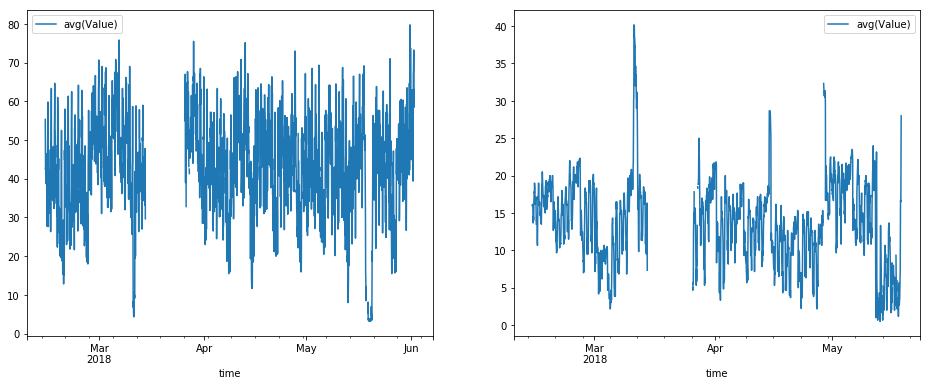

In [6]:

plt.figure(figsize=(16,6))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
cpu_time.plot(x=['time'],y=['avg(Value)'],ax=ax1)
mem_time.plot(x=['time'],y=['avg(Value)'],ax=ax2)
plt.show()

There are missing values for both time series, corresponding to the same time periods. There are several methods we can use to impute the missing values. Below shows a few methods. 

The first method is to compute the mean of the entire time series and assign the calculated mean to the missing values.

/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning:

Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access



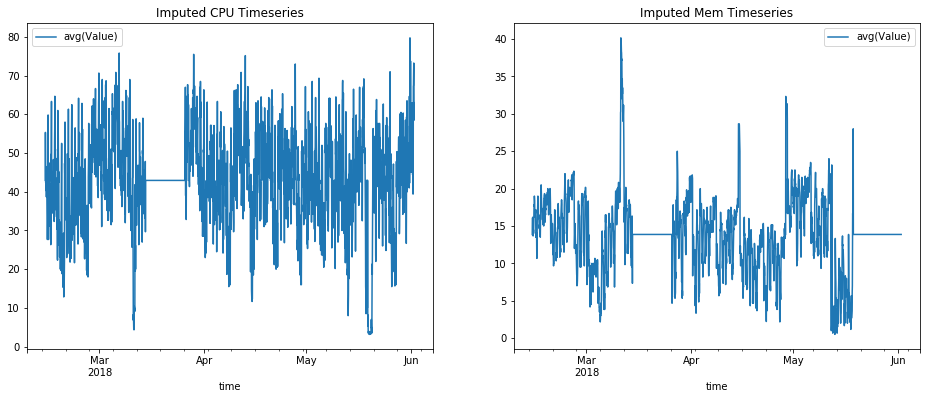

In [7]:
## Adding values based on the overall mean of the column
plt.figure(figsize=(16,6))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
cpu_filled = cpu_time.fillna(cpu_time.mean())
mem_filled = mem_time.fillna(mem_time.mean())
cpu_filled.plot(x=['time'],y=['avg(Value)'], ax=ax1, kind='line', title='Imputed CPU Timeseries')
mem_filled.plot(x=['time'],y=['avg(Value)'], ax=ax2, kind='line', title='Imputed Mem Timeseries')

There are many drawbacks of using this very simple method. Firstly, using the mean computed over the entire time series results in one static value. Currently we are using this one static value across all time steps within the time series. Secondly, calculating the mean over the whole time series averages out any temporal affects that would otherwise be present in the 'real' time series. 

One other method we can use is linear interpolation. This calculates a linear range of values depending on the first and the last values surrounding the missing values. 

/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning:

Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access



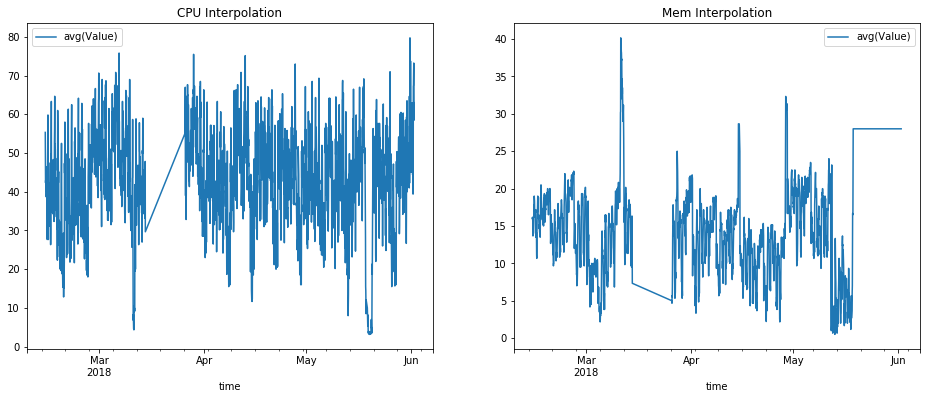

In [8]:
## Interpolating values based on linear interpolation
plt.figure(figsize=(16,6))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
cpu_inter = cpu_time.interpolate(method='linear')
mem_inter = mem_time.interpolate(method='linear')
cpu_inter.plot(x=['time'],y=['avg(Value)'], ax=ax1, kind='line', title='CPU Interpolation')
mem_inter.plot(x=['time'],y=['avg(Value)'], ax=ax2, kind='line', title='Mem Interpolation')
plt.show()

The linear interpolation misses the fluctuations we might expect the time series to exhibit within the missing range. However, this very simple method at least captures the overall trend we might expect the values to exhibit across the missing time steps. 


Next, in order to check if our time series is stationary, we can calculate the moving average and variance exhibited over time. 

<Figure size 1152x432 with 0 Axes>

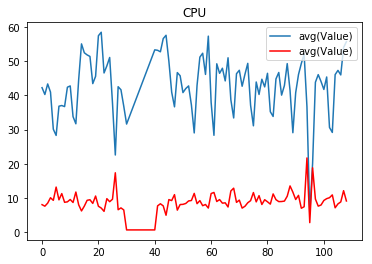

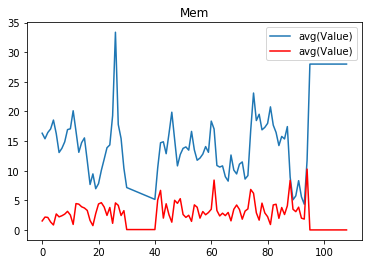

In [9]:
# Mean and variance over time - Calculate for every 24 folds within the total set of data points
plt.figure(figsize=(16,6))

cpu_average = cpu_inter.groupby(np.arange(len(cpu_inter))//24).mean()
cpu_std = cpu_inter.groupby(np.arange(len(cpu_inter))//24).std()

ax1=cpu_average.plot(kind='line', legend='Mean CPU')
cpu_std.plot(ax=ax1, kind='line', color='red', legend='Variance CPU', title='CPU')

mem_average = mem_inter.groupby(np.arange(len(mem_inter))//24).mean()
mem_std = mem_inter.groupby(np.arange(len(mem_inter))//24).std()
ax2 = mem_average.plot(kind='line', legend='Mean Mem')
mem_std.plot(ax=ax2, kind='line', color='red', legend='Variance Mem', title='Mem')
plt.show()

In [10]:
split = int(len(cpu_inter) / 4)
cpu_values = cpu_inter['avg(Value)']
mem_values = mem_inter['avg(Value)']
cpu_means = []
mem_means = []
cpu_variances = []
mem_variances = []
for i,j in zip(range(4),range(1,5)):
    l = i * split 
    k = j * split 
    X1 = cpu_values[l:k]
    X2 = mem_values[l:k]
    cpu_mean, cpu_var = X1.mean(), X1.var()
    mem_mean, mem_var = X2.mean(), X2.var()
    print('cpu mean1=%f, mem mean1=%f' % (cpu_mean,mem_mean))
    print('cpu variance1=%f, mem_var = %f' % (cpu_var, mem_var))
    cpu_means.append(cpu_mean)
    cpu_variances.append(cpu_var)
    mem_means.append(mem_mean)
    mem_variances.append(mem_var)
    

cpu mean1=42.708780, mem mean1=14.959035
cpu variance1=164.659821, mem_var = 33.897912
cpu mean1=43.742907, mem mean1=11.016607
cpu variance1=92.917797, mem_var = 27.616692
cpu mean1=43.593315, mem mean1=13.651546
cpu variance1=128.814091, mem_var = 29.309446
cpu mean1=41.044869, mem mean1=19.965715
cpu variance1=220.808167, mem_var = 91.338194


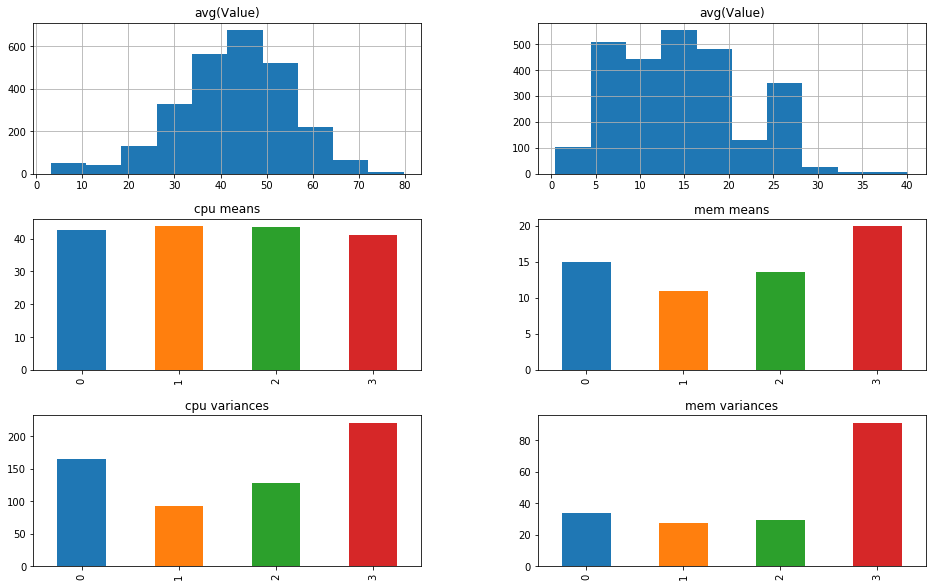

In [11]:
cpu_means = pd.Series(cpu_means)
cpu_variances = pd.Series(cpu_variances)
mem_means = pd.Series(mem_means)
mem_variances = pd.Series(mem_variances)
fg, axarr = plt.subplots(3,2, figsize=(16,10))
cpu_inter.hist(ax=axarr[0,0])
mem_inter.hist(ax=axarr[0,1])
cpu_means.plot(kind='bar', ax=axarr[1,0], title='cpu means')
cpu_variances.plot(kind='bar', ax=axarr[2,0], title='cpu variances')
mem_means.plot(kind='bar', ax=axarr[1,1], title='mem means')
mem_variances.plot(kind='bar', ax=axarr[2,1], title='mem variances')


plt.show()


The above analysis suggests that there is some dependence of variance on time, suggesting that the data set is non-stationary. We can investigate this further by computing the "Augmented Dickey-Fuller" test. 

In [12]:
# Calculate ADF 
cpu_values.dropna(inplace=True)
result = adfuller(cpu_values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -7.536841
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


<Figure size 1152x576 with 0 Axes>

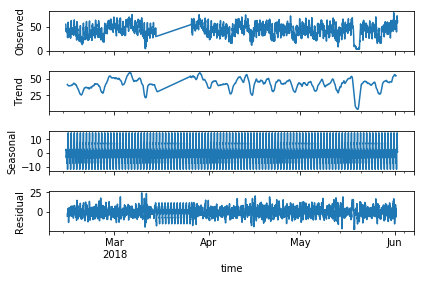

In [115]:
# Decompose time series 
result = seasonal_decompose(cpu_values, model='additive')
#print(result.trend)
#print(result.seasonal)
#print(result.resid)
#print(result.observed)
plt.figure(figsize=(16,8))
result.plot()
plt.show()

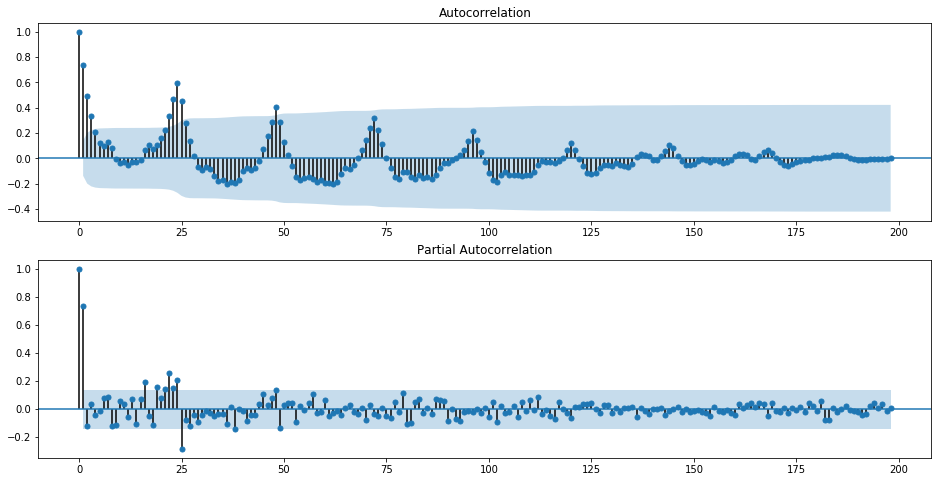

In [37]:
# Calculate ACF and PACF 

plt.figure(figsize=(16,8))
plt.subplot(211)

cpu_inter_start = cpu_inter.iloc[1:200,0]
plot_acf(cpu_inter_start, ax=plt.gca())
plt.subplot(212)
plot_pacf(cpu_inter_start, ax=plt.gca())
plt.show()

The ACF and PACF plots provide useful information about the type of models that are appropriate for this time series. 


The analysis suggests an ARIMA(p,d,0) model is appropriate based on the following observations:
- the ACF is exponentially decaying or sinusoidal;
- there is a significant spike at lag q in PACF, but none beyond lag q.

Furthermore, the ACF shows that there is no signficant correlations past the first 5 values, so we can try a range of values e.g 3-10 for the order of the autoregression (p). 

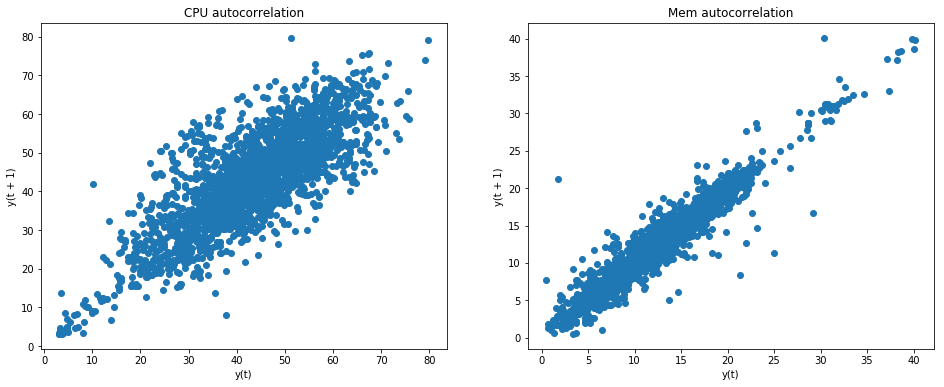

In [38]:
plt.figure(figsize=(16,6))

ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
ax=lag_plot(cpu['avg(Value)'], ax=ax1)
ax.set_title('CPU autocorrelation')
axx=lag_plot(mem['avg(Value)'], ax=ax2)
axx.set_title('Mem autocorrelation')
plt.show()

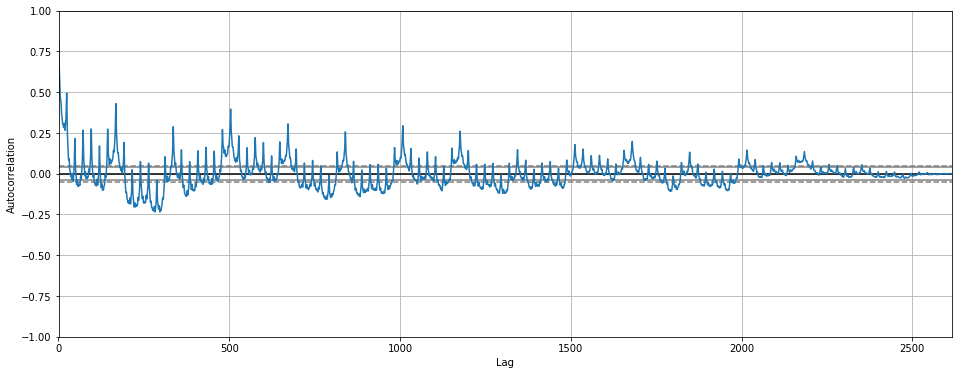

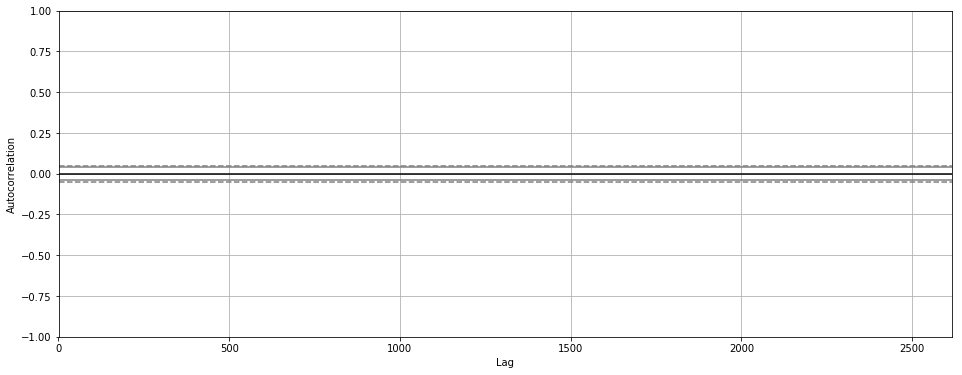

In [39]:
# CPU

plt.figure(figsize=(16,6))

autocorrelation_plot(cpu_inter['avg(Value)'])
plt.show()
plt.figure(figsize=(16,6))
autocorrelation_plot(mem_inter['avg(Value)'])
plt.show()

### ARIMA Model - CPU 

We can try a range of values, or a grid search, to generate a series of candidate models. The models will be evaluated using the following metrics:
- AIC
- BIC
- Test MSE 

The first step is to split the data into training (2/3) and test sets (1/3).

In [52]:
# split into train and test sets
X = cpu_inter['avg(Value)'].values
size = int(len(X) * 0.66)
train, test = X[:size], X[size:len(X)]
test = test[0:10]
test

array([37.83333333, 45.83333333, 47.83333333, 49.16666667, 51.        ,
       46.16666667, 50.        , 39.16666667, 39.16666667, 48.83333333])

In [41]:
X.shape

(2615,)

In [245]:
# Generate an evaluation function 

def run_model(X, order):
    # train autoregression
    size = int(len(X) * 0.66)
    train, test = X[:size], X[size:len(X)]
    test = test[0:10]
   # print(test)
    predictions = []
    history = [x for x in train]
    for i in range(len(test)):
        model = ARIMA(history, order=order)
        model_fit = model.fit(disp=0)
#        residuals = pd.DataFrame(model_fit.resid)
        yhat = model_fit.forecast()[0]
        history.append(test[i])
        predictions.append(yhat)
    mse = metrics.mean_squared_error(test, predictions)
    return mse

def fast_model(X, order):
    size = int(len(X) * 0.66)
    train, test = X[:size], X[size:len(X)]
    train_time = train.drop('time', axis=1)
    test_time = test.drop('time', axis=1)
   # print(test)
    model = ARIMA(train_time, order=order)
    model_fit = model.fit()
    testset = test[0:51]
    if order[1] > 0:
        predictions = model_fit.predict(start=len(train_time), end=len(train_time)+50, typ='levels')
    else:
        predictions = model_fit.predict(start=len(train_time), end=len(train_time)+50)
    mse = metrics.mean_squared_error(testset['avg(Value)'], predictions)
    return mse 
    

def grid_search(data, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    scores, orders = [],[]
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = fast_model(data, order)
                    print(mse)
                    scores.append(mse)
                    orders.append(order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print("ARIMA order: %s, SCORE %0.3f" % (order, mse))
                    #print("parameters: p = %s, q = %s, d = %s" % (p,q,d))
                except:
                    continue
    print("Best ARIMA order: %s, BEST SCORE: %0.3f" % (best_cfg, best_score))
    return scores, orders
        

In [247]:
# Grid search

p_values = range(0,25)
d_values = range(0,2)
q_values = range(0,2)

cpu_inter.dropna(inplace=True)
#X = cpu_inter['avg(Value)'].values
warnings.filterwarnings("ignore")
scores, orders = grid_search(cpu_inter, p_values, d_values, q_values)
#order = (1,0,0)
#mse = fast_model(cpu_inter, order)
#print("error: %s" % mse)

81.1588859323598
ARIMA order: (0, 0, 0), SCORE 81.159
80.6789568221486
ARIMA order: (0, 0, 1), SCORE 80.679
88.55446328503199
ARIMA order: (0, 1, 0), SCORE 88.554
74.08419212425407
ARIMA order: (0, 1, 1), SCORE 74.084
81.06799486157487
ARIMA order: (1, 0, 0), SCORE 81.068
81.10145783091642
ARIMA order: (1, 0, 1), SCORE 81.101
80.46244886633085
ARIMA order: (1, 1, 0), SCORE 80.462
80.38534498257091
ARIMA order: (1, 1, 1), SCORE 80.385
81.08792115432341
ARIMA order: (2, 0, 0), SCORE 81.088
81.33084708028419
ARIMA order: (2, 0, 1), SCORE 81.331
72.72037257146624
ARIMA order: (2, 1, 0), SCORE 72.720
83.77932069157825
ARIMA order: (2, 1, 1), SCORE 83.779
80.24540486980061
ARIMA order: (3, 0, 0), SCORE 80.245
80.04140788406136
ARIMA order: (3, 0, 1), SCORE 80.041
71.10589222824454
ARIMA order: (3, 1, 0), SCORE 71.106
78.61429902311
ARIMA order: (3, 1, 1), SCORE 78.614
80.14575999379763
ARIMA order: (4, 0, 0), SCORE 80.146
80.8115988396158
ARIMA order: (4, 0, 1), SCORE 80.812
69.3270106270243

<Figure size 1152x576 with 0 Axes>

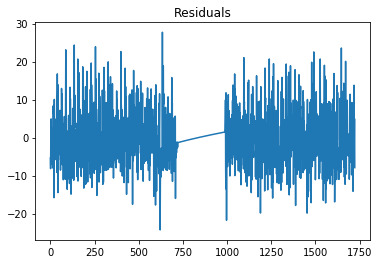

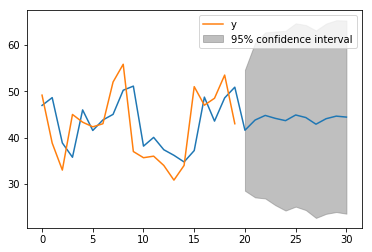

In [248]:
# train autoregression
X = cpu_inter['avg(Value)'].values
size = int(len(X) * 0.66)
train, test = X[:size], X[size:len(X)]
model = ARIMA(train, order=(13,1,1))
# fit model
model_fit = model.fit(disp=0)
#print(model_fit.summary())
# plot residual errors
plt.figure(figsize=(16,8))
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(title='Residuals', legend=False)
pyplot.show()


#generate prediction from model 

model_fit.plot_predict(start=len(train)-20, end=len(train)+10)
plt.show()

ARIMA models assume the residuals are normally distributed and uncorrelated. To inspect these properties, we run the following tests:
- Visualise the distribution of the residues through density plots
- Calculate the PACF and ACF of the residuals
- Perform Ljung-Box test for correlations


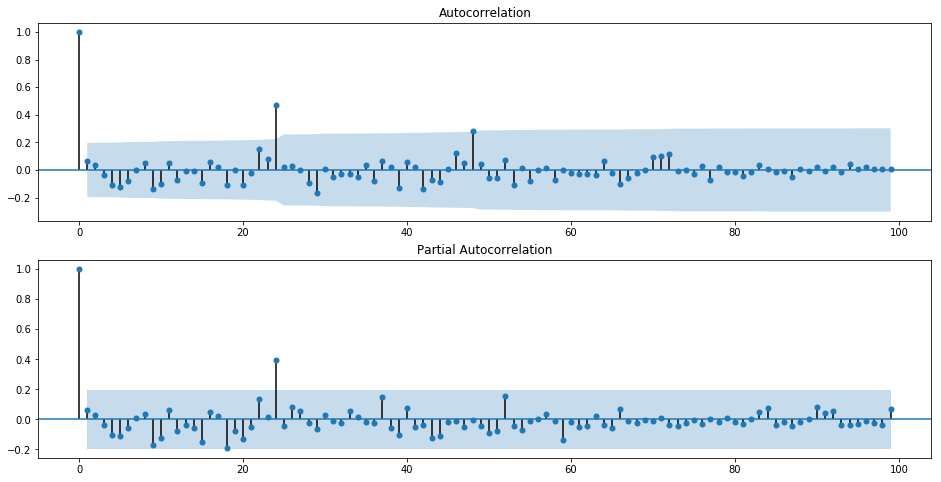

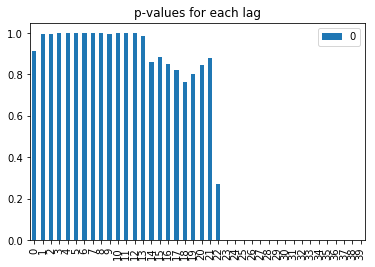

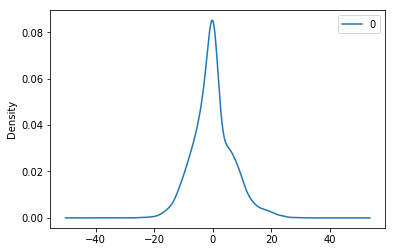

                 0
count  1724.000000
mean      0.021135
std       6.667099
min     -24.280090
25%      -3.831935
50%      -0.221603
75%       3.421903
max      27.727637


In [249]:
#inspect the correlations between the residuals
plt.figure(figsize=(16,8))
plt.subplot(211)
plot_acf(residuals[0:100], ax=pyplot.gca())
plt.subplot(212)
plot_pacf(residuals[0:100], ax=pyplot.gca())
plt.show()

#perform Ljung-Box test
test_statistic = acorr_ljungbox(residuals)[0]
p_values = acorr_ljungbox(residuals)[1]

p_val = pd.DataFrame(p_values)
p_val.plot(kind='bar', title='p-values for each lag')
plt.show()

#describe the distribution properties of the residuals
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())



In [250]:
print(p_values)

[9.14728341e-01 9.94028932e-01 9.95809664e-01 9.99480443e-01
 9.99942442e-01 9.99920842e-01 9.99981993e-01 9.99995699e-01
 9.99633880e-01 9.95347569e-01 9.97687612e-01 9.98566021e-01
 9.99305502e-01 9.83347883e-01 8.60318938e-01 8.81685392e-01
 8.48368993e-01 8.19660330e-01 7.62650944e-01 8.03975504e-01
 8.46895638e-01 8.80376862e-01 2.70639714e-01 3.59714803e-75
 1.09396093e-75 2.56795180e-76 1.04572449e-75 1.20928704e-75
 5.07475080e-76 1.35122980e-77 5.06872097e-77 1.40524073e-76
 8.83040888e-77 1.45967101e-76 5.37206061e-76 1.11427581e-75
 2.06819162e-75 9.00384100e-76 2.10592678e-77 6.86600632e-77]


The results from our tests indicate that the residuals follow a normal distribution with a zero-centered mean, and show low p-values to reject the null hypothesis that the residuals are correlated. 

Generate rolling forecast using the previously forecasted data points to recalculate the ARIMA model and generate predictions across the test set

/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning:

Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.

/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(floa

/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed 

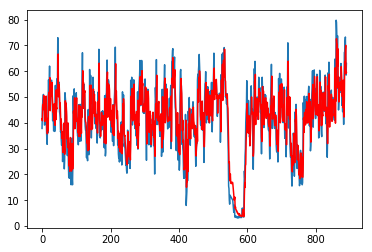

In [110]:
# Generate rolling forecast using the previously forecasted data points to recalculate the ARIMA model and generate predictions across the test set

X = cpu_inter['avg(Value)'].values
size = int(len(X) * 0.66)
train, test = X[:size], X[size:len(X)]
#test = test[0:10]

predictions = []
history = [x for x in train]
for i in range(len(test)):
    rolling = ARIMA(history, order=(13,1,1))
    rolling_fit = rolling.fit(disp=0)
#   residuals = pd.DataFrame(model_fit.resid)
    yhat = rolling_fit.forecast()[0]
    history.append(test[i])
    predictions.append(yhat)

mse = metrics.mean_squared_error(test, predictions)
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

Compare the fitted model (model_fit) to the rolling forecast model (rolling_fit)

In [68]:
print(len(train))
print(len(test))

1725
890


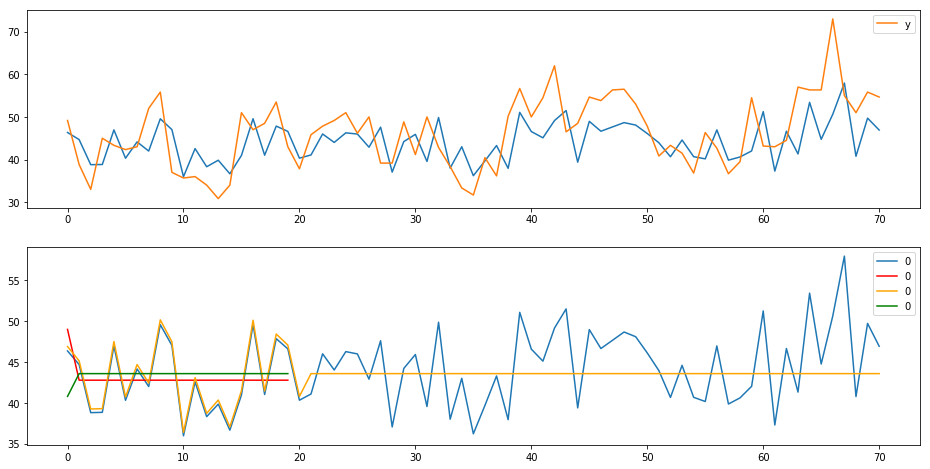

In [125]:
# Use the final fitted model from above to generate predictions 
X = cpu_inter['avg(Value)'].values
size = int(len(X) * 0.66)
train, test = X[:size], X[size:len(X)]

## Prediction
rolling_pred = rolling_fit.predict(start=len(train)-20, end=len(train)+50)
rolling_pred = pd.DataFrame(rolling_pred, index=test_time[0:50].index, columns=['rolling prediction'])
model_pred = model_fit.predict(start=len(train)-20, end=len(train)+50)
model_pred = pd.DataFrame(model_pred)

## Forecaset 

rolling_forecast = rolling_fit.forecast(steps=20)
rolling_forecast = pd.DataFrame(rolling_forecast[0], index=test_time[0].index, columns=['rolling forecast'])
model_forecast = model_fit.forecast(steps=20)
model_forecast = pd.DataFrame(model_forecast[0], index=test_time[0].index, columns['model forecast'])

## Plot
plt.figure(figsize=(16,8))
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
#ax3 = plt.subplot(313)

rolling_fit.plot_predict(start=len(train)-20, end=len(train)+50, ax=ax1)
#test = pd.DataFrame(test[0:70])
#test.plot(ax=ax2, kind='line')
rolling_pred.plot(ax=ax2, kind='line')
rolling_forecast.plot(ax=ax2, kind='line', color='red')
model_pred.plot(ax=ax2, kind='line', color='orange')
model_forecast.plot(ax=ax2, kind='line', color='green')

plt.show()

### Use auto arima
In order to compare our grid search method for finding the optimal model with other methods, we can build other models using the he auto arima model implementation from the Pyramid web framework. 

As stated in the auto_arima docs:

The auto_arima function seeks to identify the most optimal parameters for an ARIMA model, and returns a fitted ARIMA model. This function is based on the commonly-used R function, forecast::auto.arima.

The auro_arima function works by conducting differencing tests (i.e., Kwiatkowski–Phillips–Schmidt–Shin, Augmented Dickey-Fuller or Phillips–Perron) to determine the order of differencing, d, and then fitting models within ranges of defined start_p, max_p, start_q, max_q ranges. If the seasonal optional is enabled, auto_arima also seeks to identify the optimal P and Q hyper- parameters after conducting the Canova-Hansen to determine the optimal order of seasonal differencing, D.

In [82]:
# automatically generate model with auto_arima library from Pyramid 
cpu_inter.dropna(inplace=True)


# Function expects a tuple for order, specifying start and end parameters for p and q 
def auto_model(order):
    size = int(len(cpu_inter) * 0.66)
    train, test = cpu_inter[:size], cpu_inter[size:len(cpu_inter)]
    train_time = train.drop('time', axis=1)
    test_time = test.drop('time', axis=1)
    p,q, end_p, end_q = order[0], order[1], order[2], order[3]
    print(p,q,end_p,end_q)
    stepwise_model = auto_arima(train_time, start_p=p, start_q=q,
                           max_p=end_p, max_q=end_q, trace=False,
                           error_action='warn',seasonal=False,
                           suppress_warnings=True, 
                           stepwise=True, max_order=None, maxiter=100)
    print("AIC: %f" % stepwise_model.aic())
    print("AICC: %f" % stepwise_model.aicc())
    print("BICC: %f" % stepwise_model.bic())
    return stepwise_model
#print("BSE: %f" % stepwise_model.bse())



In [83]:
# generate automodel 
# Function expects a tuple for order, specifying start and end parameters for p and q 
order = (1,0,10,2)
automodel_d010 = auto_model(order)
order = (10,0,20,2)
automodel_d1020 = auto_model(order)
order = (20,0,24,2)
automodel_d2024 = auto_model(order)



1 0 10 2


/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `

AIC: 11469.023132
AICC: 11469.072054
BICC: 11501.737546
10 0 20 2


/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `

AIC: 11464.428805
AICC: 11464.557235
BICC: 11518.952829
20 0 24 2


/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `

KeyboardInterrupt: 

In [ ]:
for i in range(3):
#     print("yes")
    aic = []
    aic.append(automodel_d010.aic())
    aic.append(automodel_d1020.aic())
    aic.append(automodel_d2024.aic())
    

print(aic)

/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



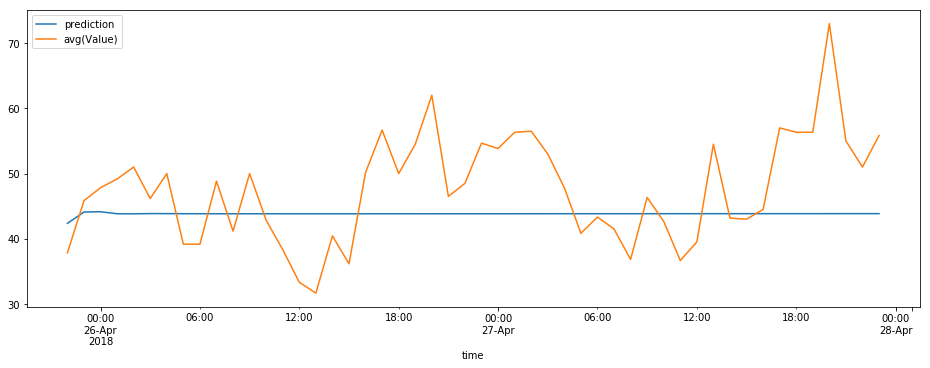

In [109]:
automodel_fit = automodel.fit(train_time)
auto_pred = automodel_fit.predict(n_periods=50)
auto_pred_time = pd.DataFrame(auto_pred,index = test_time.iloc[0:50].index,columns=['prediction'])
plt.figure(figsize=(16,12))
ax1 = plt.subplot(211)

auto_pred_time.plot(ax=ax1)
#automodel_fit.plot_predict(start=len(train_time)-20, end=len(train_time)+50, ax=ax1)
test_time.iloc[0:50].plot(ax=ax1)
plt.show()
#model_fit.plot_predict(start=len(train_time)-20, end=len(train_time)+50, ax=ax1)

In [102]:
auto_pred

array([42.36439175, 44.101949  , 44.14603313, 43.83706549, 43.82261214,
       43.86357582, 43.85660229, 43.84340765, 43.83989781, 43.83843093,
       43.83626934, 43.83454842, 43.83353994, 43.83292195, 43.83255629,
       43.83242063, 43.83247583, 43.83267688, 43.83299204, 43.83339844,
       43.83387728, 43.8344133 , 43.83499455, 43.83561165, 43.83625712,
       43.83692505, 43.83761076, 43.83831054, 43.83902146, 43.8397412 ,
       43.84046793, 43.84120018, 43.84193681, 43.8426769 , 43.84341974,
       43.84416474, 43.84491147, 43.84565955, 43.84640871, 43.84715873,
       43.84790942, 43.84866064, 43.84941229, 43.85016427, 43.85091651,
       43.85166897, 43.85242159, 43.85317434, 43.8539272 , 43.85468014])

In [106]:
auto_pred_time.head(5)

,prediction
time,
2018-04-25 22:00:00,42.364392
2018-04-25 23:00:00,44.101949
2018-04-26 00:00:00,44.146033
2018-04-26 01:00:00,43.837065
2018-04-26 02:00:00,43.822612


### Original Models 

These models use 24 lags due to variations displayed over 24 h within the CPU time series. 

### Use time for x-axis

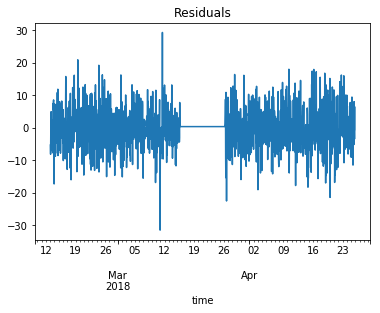

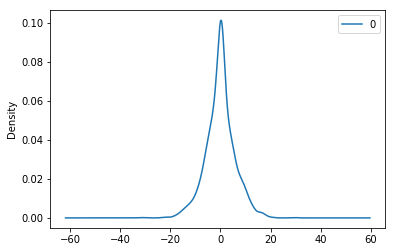

                 0
count  1724.000000
mean     -0.014202
std       5.794817
min     -31.488809
25%      -3.147771
50%       0.335450
75%       3.039379
max      29.285369


In [148]:
#data set creation
size = int(len(cpu_inter) * 0.66)
train, test = cpu_inter[:size], cpu_inter[size:len(cpu_inter)]
train_time = train.drop('time', axis=1)
test_time = test.drop('time', axis=1)
# train autoregression
model = ARIMA(train_time, order=(24,1,0))
#model_fit = model.fit()
# fit model
model_fit = model.fit(disp=0)
#print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(title='Residuals', legend=False)
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

<Figure size 1152x576 with 0 Axes>

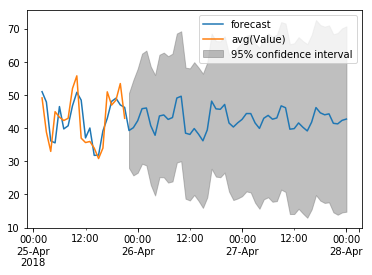

In [214]:
pred = model_fit.predict(start=len(train), end=len(train)+100, typ='levels')
#fig, ax = plt.subplots()
plt.figure(figsize=(16,8))
model_fit.plot_predict(start=len(train)-20, end=len(train)+50)
plt.show()

In [76]:
test_time.head(5)

,avg(Value)
time,
2018-04-25 22:00:00,37.833333
2018-04-25 23:00:00,45.833333
2018-04-26 00:00:00,47.833333
2018-04-26 01:00:00,49.166667
2018-04-26 02:00:00,51.000000


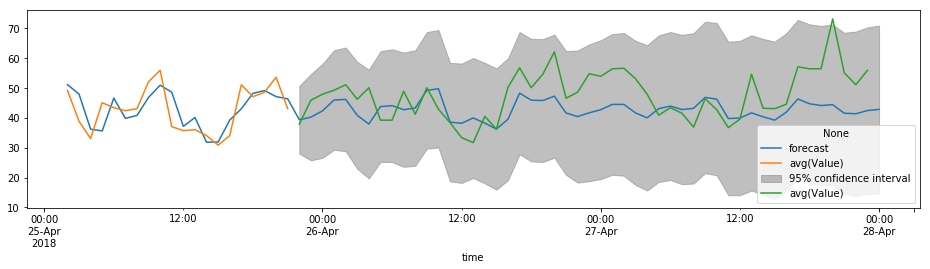

In [153]:
## Prediction

plt.figure(figsize=(16,8))
ax1 = plt.subplot(211)
#ax2 = plt.subplot(212)

model_fit.plot_predict(start=len(train_time)-20, end=len(train_time)+50, ax=ax1)
test_time.iloc[0:50].plot(ax=ax1, kind='line')
plt.show()


In [215]:
testset = test.iloc[0:51]

predictions = model_fit.predict(start=len(train_time), end=len(train_time)+50, typ='levels')
mse = metrics.mean_squared_error(testset['avg(Value)'], predictions)
print(mse)

77.58266111645395


### Save the model as a pkl object 



In [ ]:
model_fit.save('CPU_ARIMAmodel_2410.pkl')
numpy.save('CPU_ARIMAmodel_2410.npy', [lam])

### Other visualisations for forecasted data

<Figure size 1152x576 with 0 Axes>

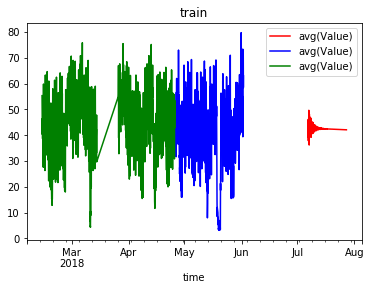

In [200]:
## Prediction

train,test = cpu_inter[:size], cpu_inter[size:len(cpu_inter)]
test['time'].astype('datetime64[ns]')

first_pred = model_fit.predict(start=len(train), end=len(train)+500, typ='levels')
first_pred = pd.DataFrame(first_pred)
first_pred.columns = ['avg(Value)']
first_pred.index += 1725

plt.figure(figsize=(16,8))
ax1 = first_pred.plot(kind='line', color='red', title='Prediction')
test.plot(x='time', y='avg(Value)', ax=ax1, kind='line', color='blue', title='test')
train.plot(x='time', y='avg(Value)',ax=ax1, kind='line', color='green', title='train')
plt.show()



Model Prediction/Forecasting

In [138]:
# split into 2/3 of data
size = int(len(cpu_inter) * 0.66)
train, test = cpu_inter[0:size], cpu_inter[size:len(cpu_inter)]
#train = train[1:,1]
history = [x for x in train['avg(Value)']]
test = np.array(test['avg(Value)'])
history = history[1:]
history
predictions = []
for i in range(len(train)):
    model = ARIMA(history, order=(24,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    #print(output)
    yhat = output[0]
    predictions.append(yhat)
    #t = 168 + i
    obs = test[i]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

#test2 = test[len(test):len(test)+10]
    
error = metrics.mean_squared_error(test, predictions)
#print('Test MSE: %.3f' % error)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

predicted=39.315072, expected=37.833333
predicted=39.032420, expected=45.833333
predicted=46.848749, expected=47.833333


KeyboardInterrupt: 

# Memory

### ARIMA Model - Mem



In [115]:
# split into train and test sets
#mem_inter.dropna(inplace=True)
#X = mem_inter['avg(Value)'].values
size_mem = int(len(mem_inter) * 0.66)
train_mem, test_mem = mem_inter[0:size], mem_inter[size:len(mem_inter)]

In [118]:
train_mem.head(1)

,_time,avg(Value)
0,2018-02-13T00:00:00.000+0000,NaN


/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


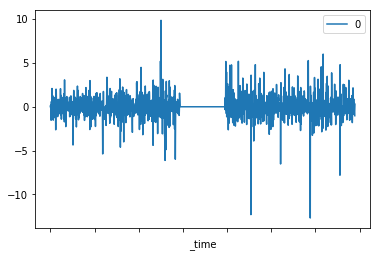

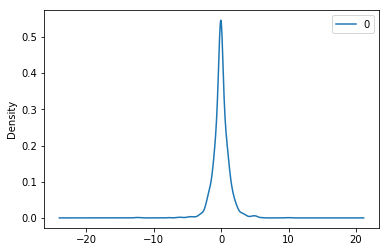

                 0
count  1724.000000
mean      0.000406
std       1.285168
min     -12.697503
25%      -0.528284
50%      -0.006145
75%       0.526848
max       9.853952


In [122]:
# train autoregression
train_mem[1:]
train_mem_time, test_mem_time = train_mem.set_index("_time"), test_mem.set_index("_time")
train_mem_time.dropna(inplace=True)
model_mem = ARIMA(train_mem_time, order=(24,1,0))

# fit model
model_mem_fit = model_mem.fit(disp=0)
#print(model_mem_fit.summary())
# plot residual errors
residuals_mem = pd.DataFrame(model_mem_fit.resid)
residuals_mem.plot()
pyplot.show()
residuals_mem.plot(kind='kde')
pyplot.show()
print(residuals_mem.describe())

Prediction

In [148]:
forecast[0]

array([11.71465868, 11.36058595, 10.39365101,  9.97094314,  9.4157416 ,
        9.25398793, 10.00294092,  9.85229249,  9.85758787,  9.29925654,
        8.99178061,  8.97856165,  9.31452209, 10.70967403, 11.18916326,
       11.41618647, 11.5854977 , 11.92824732, 11.74335685, 11.4950824 ])

/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


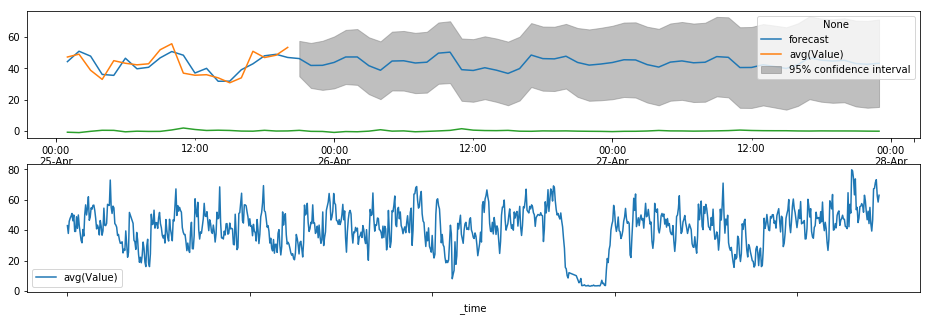

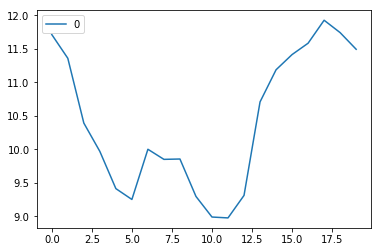

In [150]:
## Prediction
first_pred = model_mem_fit.predict(start=len(train_time)-20, end=len(train_time)+50, typ='linear')

## Forecaset 

forecast = model_mem_fit.forecast(steps=20)
forecast = pd.DataFrame(forecast[0])
plt.figure(figsize=(16,8))
ax1 = plt.subplot(311)
ax2 = plt.subplot(312)
#ax3 = plt.subplot(313)

model_time_fit.plot_predict(start=len(train_time)-20, end=len(train_time)+50, ax=ax1)
test_time.plot(ax=ax2, kind='line')
#first_pred = pd.DataFrame(first_pred)
first_pred.plot(ax=ax1, kind='line')
forecast.plot(kind='line')
plt.show()

In [ ]:
# split into 2/3 of data
size = int(len(small_mem) * 0.66)
train, test = small[0:size], small[size:len(small)]
history = [x for x in train]
predictions = []
for i in range(len(train)):
    model = ARIMA(history, order=(24,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    #print(output)
    yhat = output[0]
    predictions.append(yhat)
    t = 168 + i
    obs = test[t]
    #history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

test2 = test[len(test):len(test)+10]
    
error = metrics.mean_squared_error(test2, predictions)
#print('Test MSE: %.3f' % error)
# plot
pyplot.plot(test2)
pyplot.plot(predictions, color='red')
pyplot.show()